In [1692]:
import pandas as pd
import random
import math
import pycountry
import pypopulation
from matplotlib import pyplot as plt
from matplotlib import patches as patches

In [1693]:
csv = pd.read_csv('data.csv')


In [1694]:
df = csv.groupby(['Country_Region'])['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
df = df[["Country_Region", "Confirmed", "Deaths", "Recovered"]]

<ipython-input-1694-8454d5381422>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = csv.groupby(['Country_Region'])['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()


In [1695]:
df_scaled = df.copy()
# df_scaled['Confirmed'].plot(kind = 'bar')


population = []
to_drop = []
# print(len(df_scaled.index))
for index, row in df_scaled.iterrows():
    # print(row[1]['Country_Region'])
    if pycountry.countries.get(name=row['Country_Region']) != None:
        population.append(pypopulation.get_population_a3(pycountry.countries.get(name=row['Country_Region']).alpha_3))
        # print(index, row['Country_Region'])
        # print(pycountry.countries.get(name=row['Country_Region']).alpha_3)
    else:
        to_drop.append(index)

df_scaled = df_scaled.drop(to_drop)
df_scaled['Population'] = population
# print(to_drop)
# print(len(df_scaled.index))

# print(df_scaled)

df_scaled['Confirmed'] = (df_scaled['Confirmed']) / (df_scaled['Population'])
df_scaled['Deaths'] = (df_scaled['Deaths']) / (df_scaled['Population'])
df_scaled['Recovered'] = (df_scaled['Recovered']) / (df_scaled['Population'])

df_scaled = df_scaled[["Country_Region", "Confirmed", "Deaths", "Recovered"]]
# print(df_scaled)

df_scaled['Confirmed'] = (df_scaled['Confirmed'] - df_scaled['Confirmed'].min()) / (df_scaled['Confirmed'].max() - df_scaled['Confirmed'].min())
df_scaled['Deaths'] = (df_scaled['Deaths'] - df_scaled['Deaths'].min()) / (df_scaled['Deaths'].max() - df_scaled['Deaths'].min())
df_scaled['Recovered'] = (df_scaled['Recovered'] - df_scaled['Recovered'].min()) / (df_scaled['Recovered'].max() - df_scaled['Recovered'].min())

# df_scaled['Confirmed'] = (df_scaled['Confirmed']) / (df_scaled['Confirmed'].max())
# df_scaled['Deaths'] = (df_scaled['Deaths']) / (df_scaled['Deaths'].max())
# df_scaled['Recovered'] = (df_scaled['Recovered']) / (df_scaled['Recovered'].max())

In [1696]:
som_dim = (10, 10) # x, y dimensions
learning_rate = 0.01
iterations = 10000

radius = max(som_dim) // 2
data_dimensions = df_scaled.shape[1] - 1 #remove index from shape
time_const = iterations / math.log(radius)

neurons = [[] for _ in range(som_dim[0])]

for row in range(som_dim[0]):
    for col in range(som_dim[1]):
        neurons[row].append([random.random() for _ in range(data_dimensions)])


In [1697]:
def decaying_radius(time_const, m_iter, radius):
    final_radius = math.exp(-m_iter / time_const)
    return radius * final_radius

def decaying_learning_rate(iterations, m_iter, learning_rate):
    final_learning_rate = math.exp(-m_iter / iterations)
    return learning_rate * final_learning_rate

def neighbour_influence(radius, m_dist):
    r = 2 * (radius ** 2)
    return math.exp(-m_dist / r)

def manhattan_dist(a1, a2):
    results = []
    for i in range(len(a1)):
        result = []
        result.append(abs(a1[i]-a2[i]))

    return sum(results)

def drawColorMap(network, iteration):
  fig = plt.figure()
  ax = fig.add_subplot(111, aspect='equal')
  ax.set_xlim((0, som_dim[0]+1))
  ax.set_ylim((0, som_dim[1]+1))
  ax.set_title('Self-Organising Map after %d iteration(s)' % iteration)

  for x in range(som_dim[0]):
    for y in range(som_dim[1]):
        ax.add_patch(patches.Rectangle((x+0.5, y+0.5), 1, 1,
                                     facecolor=network[x][y][:data_dimensions],
                                     edgecolor='none', label="ASDQWE"))
        # centerx = x + 0.5
        # centery = y + 0.5
        # plt.text(centerx, centery,network[x][y][data_dimensions])

  plt.show()

done


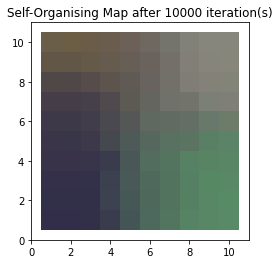

In [1698]:
for m_iter in range(iterations):
    input_vec = df_scaled.sample()
    input_vec = input_vec.values.tolist()[0][1:]
    
    dist = [] #list of tuples ( (i,j), distance )

    for row in range(som_dim[0]):
        for col in range(som_dim[1]):
            curr_neuron = neurons[row][col]
            m_dist = math.dist(input_vec, curr_neuron)
            # m_dist = manhattan_dist(input_vec, curr_neuron)
            dist.append( ((row, col),m_dist))

    
    
    neuron_ij, dist = min(dist, key=lambda x: x[1])
    bmu_weights = neurons[neuron_ij[0]][neuron_ij[1]]
    curr_radius = decaying_radius(time_const, m_iter, radius)
    curr_learning_rate = decaying_learning_rate(iterations, m_iter, learning_rate)
    # curr_learning_rate = learning_rate

    neurons_in_radius = 0

    #Updating neighbours
    
    for row in range(som_dim[0]):
        for col in range(som_dim[1]):
    # for row in range(max(0, neuron_ij[0]-int(curr_radius)), min(som_dim[0], neuron_ij[0]+int(curr_radius)+1)):
        # for col in range(max(0, neuron_ij[1]-int(curr_radius)), min(som_dim[1], neuron_ij[1]+int(curr_radius)+1)):
            curr_neuron = neurons[row][col]
            curr_neuron_dist = math.dist(bmu_weights, curr_neuron)
            # curr_neuron_dist = manhattan_dist(bmu_weights, curr_neuron)
            # print(curr_radius)
            # if curr_neuron_dist <= (curr_radius):
            # if (row-neuron_ij[0])
            if (row >= (neuron_ij[0] - int(curr_radius))) and (row < (neuron_ij[0] + int(curr_radius) + 1)) and (col >= neuron_ij[1] - int(curr_radius))  and (col < (neuron_ij[1] + int(curr_radius)+1)): 
                neurons_in_radius += 1
                curr_neuron_infl = neighbour_influence(radius, curr_neuron_dist)
                for w in range(data_dimensions):
                    updated_w = curr_learning_rate * curr_neuron_infl * (bmu_weights[w] - curr_neuron[w])
                    curr_neuron[w] += updated_w

    # if m_iter % 100 == 0:
        # print((curr_radius ** 2), neurons_in_radius, curr_neuron_dist, input_vec)

    # if m_iter % 1000 == 0:
    # #     print(neurons_in_radius)
    #     drawColorMap(neurons, m_iter)
        # print(neurons)
        # break
print("done")
# for row in range(som_dim[0]):
#         for col in range(som_dim[1]):
#             neurons[row][col].append([])

# for index, row in df_scaled.iterrows():
#     input_vec = row
#     country = input_vec.values.tolist()[0]
#     input_vec = input_vec.values.tolist()[1:]
#     dist = []
#     for row in range(som_dim[0]):
#         for col in range(som_dim[1]):
#             curr_neuron = neurons[row][col]
#             m_dist = math.dist(input_vec, curr_neuron[:data_dimensions])
#             # m_dist = manhattan_dist(input_vec, curr_neuron)
#             dist.append( ((row, col),m_dist))
    
#     neuron_ij, dist = min(dist, key=lambda x: x[1])
#     neurons[neuron_ij[0]][neuron_ij[1]][-1].append(pycountry.countries.get(name=country).alpha_3)
drawColorMap(neurons, iterations)

